# Annotation mapping

In this example, we show how to use {func}`moscot.problems.space.annotation_mapping`.

:::{seealso}
- See {doc}`200_cell_transitions` on how to compute and plot cell transitions.
:::

## Imports and data loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

# from numba.core.errors import NumbaDeprecationWarning
from tqdm import TqdmWarning

# warnings.simplefilter("ignore", category=NumbaDeprecationWarning)
warnings.filterwarnings("ignore", category=TqdmWarning)
warnings.simplefilter("ignore", UserWarning)

import moscot as mt
from moscot import datasets
from moscot.problems.space import MappingProblem

import numpy as np

import seaborn as sns

import scanpy as sc

Load the {func}`~moscot.datasets.drosophila` dataset.

In [3]:
adata_sc = datasets.drosophila(spatial=False)
adata_sp = datasets.drosophila(spatial=True)
adata_sc, adata_sp

c:\Users\adwol\anaconda3\envs\moscot_dev\Lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
c:\Users\adwol\anaconda3\envs\moscot_dev\Lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


(AnnData object with n_obs × n_vars = 1297 × 2000
     obs: 'n_counts'
     var: 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
     uns: 'hvg', 'log1p', 'pca'
     obsm: 'X_pca'
     varm: 'PCs'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 3039 × 82
     obs: 'n_counts'
     var: 'n_counts'
     uns: 'log1p', 'pca'
     obsm: 'X_pca', 'spatial'
     varm: 'PCs'
     layers: 'counts')

## Cluster the data

In [4]:
sc.pp.neighbors(adata_sc)
sc.pp.neighbors(adata_sp)

In [5]:
sc.tl.umap(adata_sc)
sc.tl.umap(adata_sp)

In [6]:
sc.tl.leiden(adata_sc, resolution=0.57)  # low resolution
sc.tl.leiden(adata_sp, resolution=0.57)

In [7]:
adata_sc.obs.leiden = adata_sc.obs.leiden.astype("category")
adata_sp.obs.leiden = adata_sp.obs.leiden.astype("category")

c:\Users\adwol\anaconda3\envs\moscot_dev\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
c:\Users\adwol\anaconda3\envs\moscot_dev\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


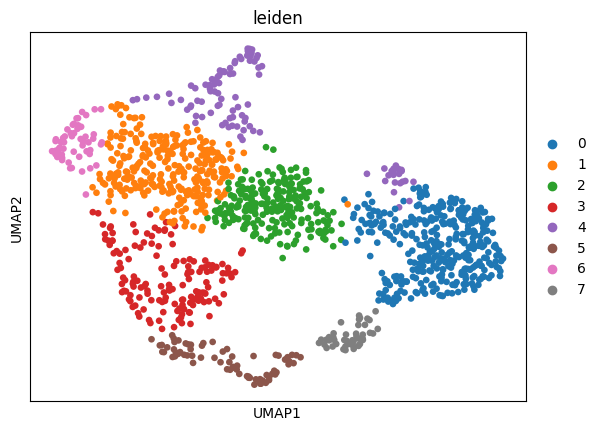

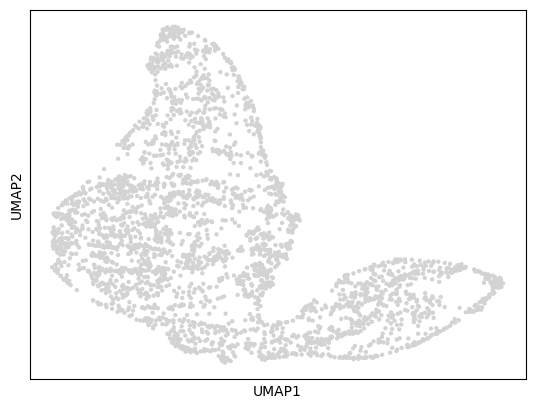

In [8]:
sc.pl.umap(adata_sc, color="leiden")
sc.pl.umap(adata_sp)

In [9]:
adata_sc

AnnData object with n_obs × n_vars = 1297 × 2000
    obs: 'n_counts', 'leiden'
    var: 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [10]:
adata_sp

AnnData object with n_obs × n_vars = 3039 × 82
    obs: 'n_counts', 'leiden'
    var: 'n_counts'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'spatial', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

## Prepare and solve the problem

In [11]:
mp = MappingProblem(adata_sc=adata_sc, adata_sp=adata_sp)

In [12]:
mp = mp.prepare(
    sc_attr={"attr": "obsm", "key": "X_pca"}, kwargs={"callback_kwargs": "local_pca"}
)

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Normalizing spatial coordinates of `x`.                                                                   


c:\Users\adwol\anaconda3\envs\moscot_dev\Lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [13]:
mp = mp.solve()

INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(3039, 1297)].                                          


Create the annotation mapping of leiden clusters from `adata_sc` to `adata_sp`.

In [14]:
mp.solutions

{('src', 'tgt'): OTTOutput[shape=(3039, 1297), cost=1.6444, converged=True]}

In [15]:
anno_map = mp.annotation_mapping(
    "max", "leiden", source="src", forward=True, key_added="leiden_max"
)  # add as obs in _sp

In [16]:
anno_map = mp.annotation_mapping("max", "leiden", forward=True)
anno_map

['0', '0', '0', '0', '0', ..., '0', '0', '0', '0', '0']
Length: 3039
Categories (1, object): ['0']

c:\Users\adwol\anaconda3\envs\moscot_dev\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
c:\Users\adwol\anaconda3\envs\moscot_dev\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


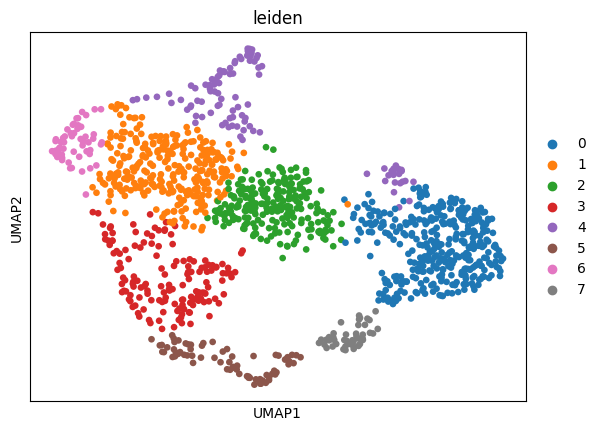

c:\Users\adwol\anaconda3\envs\moscot_dev\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
c:\Users\adwol\anaconda3\envs\moscot_dev\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\adwol\anaconda3\envs\moscot_dev\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
c:\Users\adwol\anaconda3\envs\moscot_dev

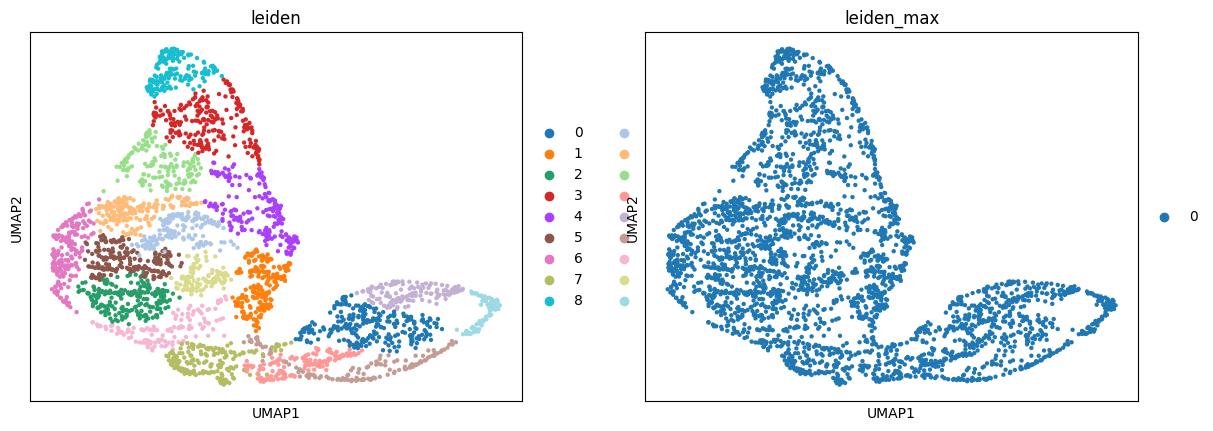

In [17]:
sc.pl.umap(adata_sc, color="leiden")
sc.pl.umap(adata_sp, color=["leiden", "leiden_max"])

In [18]:
cell_transition_kwargs = {
    "source": "src",
    "target": "tgt",
    "source_groups": None,
    "target_groups": "leiden",
    "forward": True,
    "aggregation_mode": "cell",
    "batch_size": 512,
}

In [31]:
mp.adata_sc

AnnData object with n_obs × n_vars = 1297 × 2000
    obs: 'n_counts', 'leiden'
    var: 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [19]:
mp.adata_sp

AnnData object with n_obs × n_vars = 3039 × 82
    obs: 'n_counts', 'leiden', 'leiden_max'
    var: 'n_counts'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'leiden_max_colors'
    obsm: 'X_pca', 'spatial', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [ ]:
df = mp.cell_transition(
    source="src",
    target="tgt",
    # source_groups="leiden",
    target_groups="leiden",
    forward=True,
    aggregation_mode="cell",
    # batch_size=512,
)

In [30]:
df = mp.cell_transition(
    source="src",
    target="tgt",
    # source_groups="leiden",
    target_groups="leiden",
    forward=True,
    aggregation_mode="cell",
    # batch_size=512,
)

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory allocating 47913882948 bytes.

In [21]:
df

,3,6,0,4,5,2,7,1
0,1.434888e-01,4.652876e-25,1.756840e-07,7.017866e-10,3.066467e-01,3.910540e-01,1.587718e-01,3.846730e-05
1,6.976784e-04,3.327487e-32,1.217650e-07,5.111803e-11,3.300075e-02,4.173125e-04,9.658841e-01,2.940670e-10
2,6.016123e-03,2.200387e-28,1.691675e-06,1.129851e-10,8.909101e-01,3.259449e-04,1.027461e-01,1.148409e-10
3,2.388648e-04,0.000000e+00,4.965640e-08,1.454221e-10,1.808027e-01,7.845322e-05,8.188799e-01,3.334398e-12
4,3.856310e-01,1.871830e-25,1.092741e-07,6.504495e-10,7.097898e-02,5.416000e-01,1.750970e-03,3.896693e-05
...,...,...,...,...,...,...,...,...
3034,1.407364e-04,6.749710e-15,4.931012e-03,4.099478e-06,6.472051e-12,5.161223e-01,1.453232e-14,4.788019e-01
3035,4.501512e-03,9.924150e-01,8.816971e-14,1.968751e-04,3.103077e-19,2.608133e-05,8.296434e-23,2.860536e-03
3036,1.402716e-10,0.000000e+00,7.049098e-01,1.381340e-12,8.870167e-02,2.161479e-04,2.061723e-01,1.485406e-12
3037,2.868946e-22,0.000000e+00,1.000000e+00,9.028344e-10,2.733545e-10,6.437655e-15,3.852882e-11,7.918015e-21


In [22]:
mp.adata_sp.uns["moscot_results"]

{'cell_transition': {'cell_transition': {'source': 'src',
   'target': 'tgt',
   'source_groups': 'cell',
   'target_groups': 'leiden',
   'transition_matrix':                  3             6             0             4             5  \
   0     1.434888e-01  4.652876e-25  1.756840e-07  7.017866e-10  3.066467e-01   
   1     6.976784e-04  3.327487e-32  1.217650e-07  5.111803e-11  3.300075e-02   
   2     6.016123e-03  2.200387e-28  1.691675e-06  1.129851e-10  8.909101e-01   
   3     2.388648e-04  0.000000e+00  4.965640e-08  1.454221e-10  1.808027e-01   
   4     3.856310e-01  1.871830e-25  1.092741e-07  6.504495e-10  7.097898e-02   
   ...            ...           ...           ...           ...           ...   
   3034  1.407364e-04  6.749710e-15  4.931012e-03  4.099478e-06  6.472051e-12   
   3035  4.501512e-03  9.924150e-01  8.816971e-14  1.968751e-04  3.103077e-19   
   3036  1.402716e-10  0.000000e+00  7.049098e-01  1.381340e-12  8.870167e-02   
   3037  2.868946e-22  0.000000e+

In [25]:
anno_map = mp.annotation_mapping(
    "sum",
    "leiden",
    forward=True,
    cell_transition_kwargs=cell_transition_kwargs,
)  # key_added="leiden_sum")
anno_map

C:\Users\adwol\Desktop\helmholtz\moscot\src\moscot\base\problems\_mixins.py:505: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  to_app = df_1[df_1[annotation_key].isin(annotations_2)].groupby(annotation_key).sum().transpose()
C:\Users\adwol\Desktop\helmholtz\moscot\src\moscot\base\problems\_mixins.py:506: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tm = pd.concat([tm, to_app], verify_integrity=True, axis=0)
C:\Users\adwol\Desktop\helmholtz\moscot\src\moscot\base\problems\_mixins.py:505: FutureWarning: The default of observed=False is deprecated and wi

,3,6,0,4,5,2,7,1
0,1.434888e-01,4.652876e-25,1.756840e-07,7.017866e-10,3.066467e-01,3.910540e-01,1.587718e-01,3.846730e-05
1,6.976784e-04,3.327487e-32,1.217650e-07,5.111803e-11,3.300075e-02,4.173125e-04,9.658841e-01,2.940670e-10
2,6.016123e-03,2.200387e-28,1.691675e-06,1.129851e-10,8.909101e-01,3.259449e-04,1.027461e-01,1.148409e-10
3,2.388648e-04,0.000000e+00,4.965640e-08,1.454221e-10,1.808027e-01,7.845322e-05,8.188799e-01,3.334398e-12
4,3.856310e-01,1.871830e-25,1.092741e-07,6.504495e-10,7.097898e-02,5.416000e-01,1.750970e-03,3.896693e-05
...,...,...,...,...,...,...,...,...
3034,1.407364e-04,6.749710e-15,4.931012e-03,4.099478e-06,6.472051e-12,5.161223e-01,1.453232e-14,4.788019e-01
3035,4.501512e-03,9.924150e-01,8.816971e-14,1.968751e-04,3.103077e-19,2.608133e-05,8.296434e-23,2.860536e-03
3036,1.402716e-10,0.000000e+00,7.049098e-01,1.381340e-12,8.870167e-02,2.161479e-04,2.061723e-01,1.485406e-12
3037,2.868946e-22,0.000000e+00,1.000000e+00,9.028344e-10,2.733545e-10,6.437655e-15,3.852882e-11,7.918015e-21


In [26]:
mp.adata_sc

AnnData object with n_obs × n_vars = 1297 × 2000
    obs: 'n_counts', 'leiden'
    var: 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [29]:
len(mp.adata)

3039

In [ ]:
sc.pl.umap(adata_sc, color="leiden")
sc.pl.umap(adata_sp, color=["leiden", "leiden_sum"])